# 4. PRELIMINARY FEATURE-FLAG STUDY

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from tqdm import tqdm
import datetime as dt
from datetime import datetime
from matplotlib import pyplot, dates
from lifelines import KaplanMeierFitter
import time
import seaborn as sns
import re
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

#### get resources

In [2]:
create_files = True

resource_path = "resources/raw/"
output_path = 'results'

file_name = 'history_feature_flags.json'

# Example project
project_name = 'facebook__react'

In [3]:
def get_projects():
    project_names = [name for name in os.listdir(resource_path) if os.path.isdir(resource_path + name)]
    resources = {}
    for p in project_names:
        files = [name for name in os.listdir(resource_path + '/' + p)]
        resources[p] = files
    return resources

In [4]:
key_start = 'start'
key_end = 'end'
key_span = 'removed flag'
key_span_alive = 'alive flag'

## Statistics about open-source feature flagging projects

In [5]:
def create_stats():
    projects = get_projects()
    
    infos = {}
    
    for project in projects:
        with open('%s%s/info.json' % (resource_path, project)) as json_file:
            data = json.load(json_file)
            infos[project] = {}
            for key in ['size', 'stargazers_count', 'forks_count', 'language', 'description']:
                infos[project][key] = data[key]
    return infos

In [6]:
stats = create_stats()
stats['chromium__chromium']['language'] = 'C++'
stats['WebKit__webkit']['language'] = 'C++'
stats['rogerwang__WebKit_trimmed']['language'] = 'C++'



In [7]:
def plot_stats(stats, column):
    df_stats = pd.DataFrame(stats, index=[column]).T
    plot = df_stats.plot.box(figsize=(0.5,2), logy=True, yticks= [100, 10000, 1000000])

    plot.spines['top'].set_visible(False)
    plot.spines['right'].set_visible(False)
    plt.xticks([])
    plt.ylim(1, None)
    plot.get_figure().savefig('%s.pdf' % column, format='pdf', bbox_inches="tight")

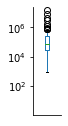

In [8]:
plot_stats(stats, 'size')

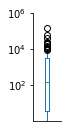

In [9]:
plot_stats(stats, 'stargazers_count')

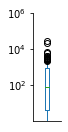

In [10]:
plot_stats(stats, 'forks_count')

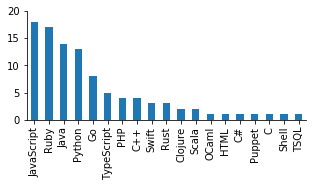

In [11]:
df_stats = pd.DataFrame(stats, index=['language']).T
df_language_counts = pd.DataFrame(df_stats['language'].value_counts())
plot = df_language_counts.plot.bar(figsize=(5,2), rot=90)
plt.ylim(0, 20)

plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
plot.get_legend().remove()

plot.get_figure().savefig('languages.pdf', format='pdf', bbox_inches="tight")

In [12]:
df_stats = pd.DataFrame(stats, index=['description', 'size', 'language']).T
df_stats.fillna("", inplace=True)
df_stats.sort_values('size', inplace=True, ascending=False)
df_stats.to_csv('statistics.csv')
df_stats.head()

,description,size,language
chromium__chromium,The official GitHub mirror of the Chromium source,16013913,C++
WebKit__webkit,Unofficial mirror of the WebKit SVN repository,7847572,C++
rogerwang__WebKit_trimmed,copy of https://git.chromium.org/git/external/WebKit_trimmed.git,4400678,C++
LineageOS__android_frameworks_base,,3115788,Java
kangdroid-project__platform_cts,,1812511,Java


## create live spans of flags (creation to removal)

In [13]:
# use the dataframe directly
def getLiveSpan(project_name, file_name):
    if file_name == "info.json":
        print("ERROR used %s" % file_name)
    start_time = 99999999999999
    max_end = -1

    livespan = {}
    

    with open('%s%s/%s' % (resource_path,project_name,file_name)) as json_file:
        data = json.load(json_file)
            
        previous_time = 0
        for commit in reversed(data['commits']):
            date = commit['date']
            if date.count(' ') == 5:
                date = date[0:date.rfind(' ')]
            time_stamp = time.mktime(datetime.strptime(date, '%a %b %d %H:%M:%S %Y').timetuple())
            time_stamp = time_stamp / (60 * 60 * 24)
            if time_stamp < previous_time:
                print(time_stamp)
            for flag in commit['flags']:
                flag_name = flag
                change = commit['flags'][flag]
                start = 99999999999999
                end = -1
                
                if flag_name in livespan:
                    start = livespan[flag_name][key_start]
                    end = livespan[flag_name][key_end]
                
                if time_stamp > max_end:
                    max_end = time_stamp
                if time_stamp < start_time:
                    start_time = time_stamp

                if change == 'True' or change == "False":
                    if flag_name in livespan:
                        if time_stamp > livespan[flag_name][key_end]:
                            end = -1
                    if time_stamp < start:
                        start = time_stamp

                if change == 'removed':
                    if time_stamp > end:
                        end = time_stamp
                
                livespan[flag_name] = {key_start: start, key_end: end, key_span : end - start, key_span_alive : 0}
    
    max_end = max_end - start_time
    max_end = max_end + 7
    
    for flag_name in livespan:
        livespan[flag_name][key_start] = livespan[flag_name][key_start] - start_time
        livespan[flag_name][key_end] = livespan[flag_name][key_end] - start_time
    
    for flag_name in livespan:
        if livespan[flag_name][key_end] < 0:
            livespan[flag_name][key_end] = max_end        
            livespan[flag_name][key_span] = 0
            livespan[flag_name][key_span_alive] = livespan[flag_name][key_end] - livespan[flag_name][key_start]
    return livespan

In [14]:
def createPlot(projectName, file_name):
    live_df = pd.DataFrame(getLiveSpan(projectName, file_name)).T
    live_df.sort_values(by=[key_start, key_end], inplace=True)
    plot = live_df.loc[:,[key_start, key_span, key_span_alive]].plot.barh(stacked=True, color='wbr', figsize=(20,5 + live_df.shape[0] / 5), title = projectName)
    plt.xlabel('days')
    return plot

### save live span plots

In [15]:
if create_files:
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    resources = get_projects()

    pairs = []
    for project in resources:
        for file in resources[project]:
            if 'history_feature_flags.json' == file:
                pairs.append((project, file))

    for res in tqdm(pairs):
        if not os.path.isdir('%s/%s' % (output_path, res[0])):
            os.mkdir('%s/%s' % (output_path, res[0]))
        plot = createPlot(res[0], res[1])
        plot.get_figure().savefig('%s/%s/%s.pdf' % (output_path, res[0], 'Livespan'), format='pdf')
        plt.close(plot.get_figure())

100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


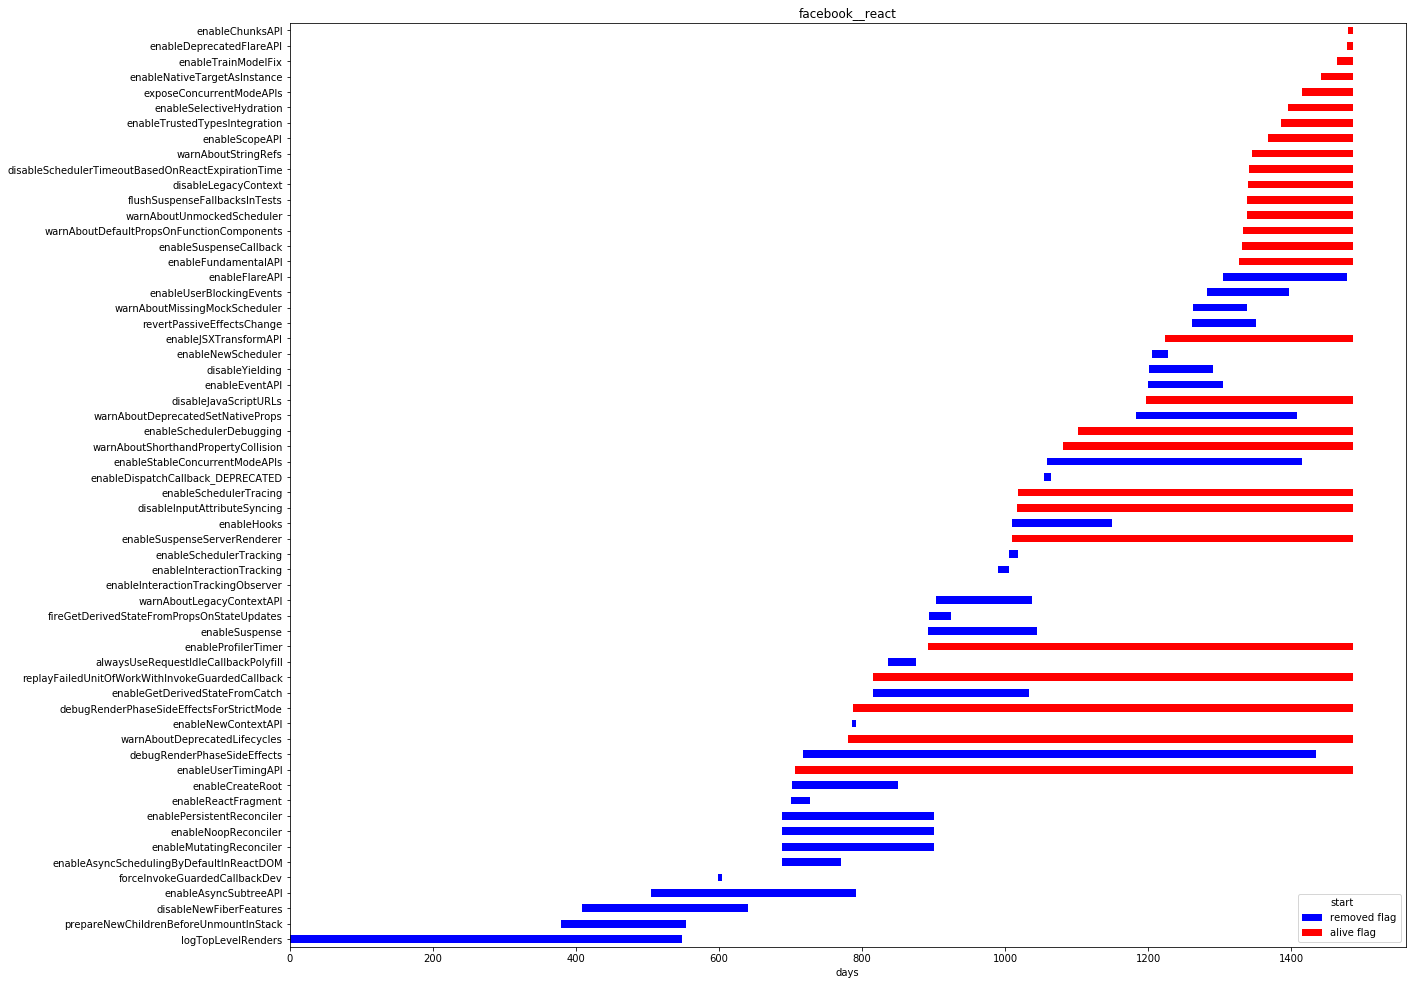

In [16]:
plot = createPlot(project_name, file_name)

## create live span plots (number of flags alive and removed)

In [17]:
def create_live_span(project_name, file_name):
    live_span = getLiveSpan(project_name, file_name)

    max_time = 0
    for flag in live_span:
        end = live_span[flag][key_end]
        if end > max_time:
            max_time = end

    live_flags = np.zeros(int(max_time))
    all_flags = np.zeros(int(max_time))
    removed_flags = np.zeros(int(max_time))
    live_time_flags = np.zeros(int(max_time))
    durations = []
    for flag in live_span:
        start = int(live_span[flag][key_start])
        end = int(live_span[flag][key_end])
        num_days = end - start
        np.add.at(live_flags, np.arange(start,end), 1)
        np.add.at(all_flags, np.arange(start,int(max_time)), 1)
        np.add.at(removed_flags, np.arange(end,int(max_time)), 1)
        np.add.at(live_time_flags, np.arange(0,end - start), 1/len(live_span))
        durations.append(num_days)
    return live_flags, removed_flags, all_flags, live_time_flags, durations

In [18]:
projects = get_projects()

for project in tqdm(projects):
    for file in projects[project]:
        if file == "history_feature_flags":
            if not os.path.isdir('%s/%s' % (output_path, project)):
                os.mkdir('%s/%s' % (output_path, project))

            # plot number of flags over time
            live_flags, removed_flags, all_flags, live_time_flags, durations = create_live_span(project, file)
            plot = pd.DataFrame({'alive': live_flags, "removed": removed_flags, 'created': all_flags}).plot(figsize=(5,5), title="%s %s" % (project, file))
            plot.get_figure().savefig('%s/%s/counts.pdf' % (output_path, project), format='pdf')
            plt.close(plot.get_figure())

            # plot survival curves   
            plot = pd.DataFrame({'live time': live_time_flags}).plot(figsize=(5,5))
            vals = plot.get_yticks()
            plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
            plot.get_figure().savefig('%s/%s/survival.pdf' % (output_path, project), format='pdf')
            plt.close(plot.get_figure())       

100%|██████████| 100/100 [00:00<00:00, 99983.41it/s]


## create author plots

In [19]:
projects = get_projects()


author_stats = {}
removed_stats = {}
relations = {}

authors = {}

livespans_authors = {'same': [], 'different': []}

flag_start = {}
for project in tqdm(projects):
    if project in ['department-of-veterans-affairs__vets-website', 'dantehemerson__gitter-webap-mirror', 'Augmint__augmint-web']:
        continue
        
    authors[project] = {'removers':{}, 'adders':{}}
    
    for file in projects[project]:
        if file == 'info.json' or file == 'history_features_old.json' or 'messages_' in file or 'commit_history.json' == file:
            continue
            
        flag_authors = {}
        with open('%s%s/%s' % (resource_path, project, file)) as json_file:
            data = json.load(json_file)
            for commit in reversed(data['commits']):
                date = commit['date']
                if date.count(' ') == 5:
                    date = date[0:date.rfind(' ')]
                time_stamp = time.mktime(datetime.strptime(date, '%a %b %d %H:%M:%S %Y').timetuple())
                author = commit['author'].split('<')[0]
                for flag in commit['flags']:
                    flag_name = flag
                    if flag_name not in flag_start:
                        flag_start[flag_name] = time_stamp
                        
                    if commit['flags'][flag] == 'removed':
                        authors[project]['removers'][author] = authors[project]['removers'].get(author, 0) + 1
                    
                    if flag_name in flag_authors:
                        if commit['flags'][flag] == 'removed':
                            duration = time_stamp - flag_start[flag_name]
                            flag_authors[flag_name][1] = author
                            
                            if duration > 0:
                                if author == flag_authors[flag_name][0]:
                                    livespans_authors['same'].append(int(duration / (60 * 60 * 24)))
                                else:
                                    livespans_authors['different'].append(int(duration / (60 * 60 * 24)))
                            
                    else:
                        authors[project]['adders'][author] = authors[project]['adders'].get(author, 0) + 1
                        flag_authors[flag_name] = [author, 'None']

        count_same_author = 0
        count_different_author = 0
        count_removed_flags = 0
        
        for flag in flag_authors:
            a = flag_authors[flag]
            if a[1] != 'None':
                count_removed_flags += 1
                if a[0] == a[1]:
                    count_same_author += 1
                else: 
                    count_different_author += 1
        
        author_stats[project] = {'alive flags' : 100/(len(flag_authors)) * (len(flag_authors) - count_removed_flags),
                                          'same author': 100/(len(flag_authors)) * count_same_author,
                                          'different author': 100/(len(flag_authors)) * count_different_author}
        # TODO count_removed_flags can be 0
        if count_removed_flags == 0:
            removed_stats[project] = {'same author': 0, 'different author': 0}
            same_author_percentage = 0
            removed_flags_percentage = 0
        else:
            removed_stats[project] = {'same author': 100/((count_removed_flags)) * count_same_author,
                                              'different author': 100/((count_removed_flags)) * count_different_author}
            same_author_percentage = 100/count_removed_flags * count_same_author
            removed_flags_percentage = 100/len(flag_authors) * count_removed_flags

        relations[project] = {'same author':same_author_percentage,
                              'removed': removed_flags_percentage,
                              'count': len(flag_authors),
                              'size' : len(flag_authors)}
        


100%|██████████| 100/100 [00:00<00:00, 218.46it/s]


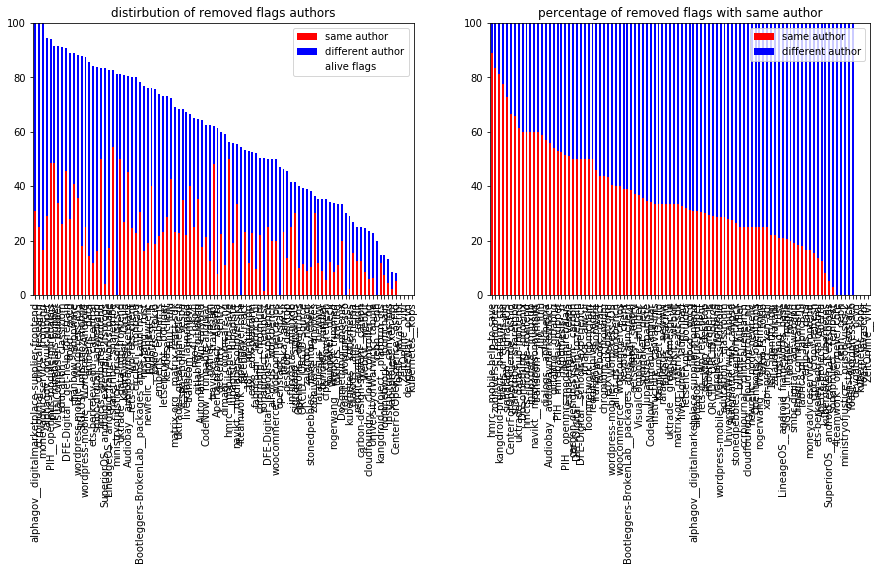

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

df_author = pd.DataFrame(author_stats).T
df_author.sort_values(by=['alive flags'], inplace=True, ascending=True)
plot = df_author.loc[:,['same author', 'different author', 'alive flags']].plot.bar(color='rbw',figsize=(15,5), stacked=True, ax=ax1,  title='distirbution of removed flags authors')
plot.set_ylim(0, 100)

df_removed = pd.DataFrame(removed_stats).T
df_removed.sort_values(by=['same author', 'different author'], inplace=True,ascending=False)
plot = df_removed.loc[:,['same author', 'different author']].plot.bar(color='rb', figsize=(15,5), stacked=True, ax=ax2, title='percentage of removed flags with same author')
plot.set_ylim(0, 100)
plt.show()

### How clean are projects where the same authors (have to) cleanup the flags?

In [21]:
df_relations = pd.DataFrame(relations).T

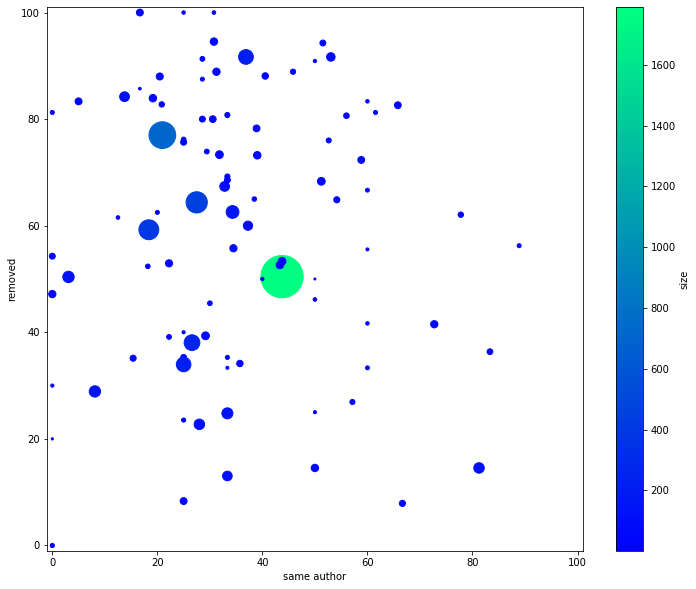

In [22]:
fig, ax = plt.subplots()
plot = df_relations.plot.scatter(x='same author', y='removed', c='size', s=df_relations['count'], colormap='winter', figsize=(12,10), ax=ax)
plot.set_xlim(-1, 101)
plot.set_ylim(-1, 101)
plt.show()

### Are flags that are removed by the same author also removed earlier?

In [23]:
df_livespans_authors_same = pd.DataFrame(livespans_authors['same'], columns=['days'])
df_livespans_authors_different = pd.DataFrame(livespans_authors['different'], columns=['days'])

min_days = 1
df_livespans_authors_different = df_livespans_authors_different[df_livespans_authors_different['days'] >= min_days]
df_livespans_authors_same = df_livespans_authors_same[df_livespans_authors_same['days'] >= min_days]

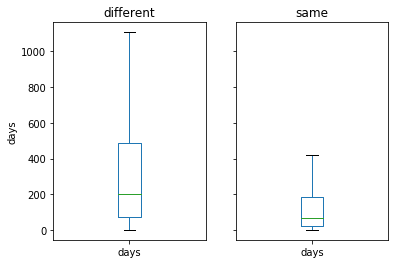

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set(ylabel='days')
df_livespans_authors_different.plot.box(title='different', ax=ax1, showfliers = False)
df_livespans_authors_same.plot.box(title='same', ax=ax2, showfliers = False)

plt.show()

In [25]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(livespans_authors['same'], livespans_authors['different'])
alpha = 0.01
print('Flags that are removed by the same author also removed earlier: %s (p=%.3f)' % (str(p < alpha), p))

Flags that are removed by the same author also removed earlier: True (p=0.000)


In [26]:
def stats(df):
    mean = df['days'].mean()
    median = df['days'].median()
    max = df['days'].max()
    print('mean: %d median: %d max: %d' % (mean, median, max))

In [27]:
print('same author:')
stats(df_livespans_authors_same)
print('different author:')
stats(df_livespans_authors_different)

same author:
mean: 134 median: 69 max: 2378
different author:
mean: 377 median: 200 max: 5284
